In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
import nibabel as nib
from os import listdir
from os.path import isfile, join
from scipy import signal
import sys
from Helpers import save_nifti

# current path
cur_path = os.getcwd()
# file name and path
file = "BB_003_3T_cmrr_mbep2d_diff_0pt2_1_task_18s_off_12s_on_20200710180104_8"
path_ref = cur_path + "/" + file

file_name = cur_path + "/data/topup/dfmri_degibbs_sdc.nii.gz"
# loading nifti object/header
raw_data_ = nib.load(file_name)
header  = raw_data_.header
affine = raw_data_.affine
raw_data = raw_data_.get_fdata()

### 1. Motion correction
#### 1.1 Split b0 and b1 values

In [2]:
def gzip(filename: str, zip: bool) -> str:
    """
    Function that zips or unzips the filename file
    Args:
        filename (str)
        zip (bool): true -> zip, false -> unzip
    Returns:
        new_filename (str)
    """
    if zip == False:
        new_filename = filename.replace('.gz', '')
        os.system(f"gzip -f -c -d {filename} > {new_filename}")
    elif zip == True:
        os.system(f"gzip {filename} -f")
        new_filename = f'{filename}.gz'
    else:
        new_filename = None
        
    return new_filename


In [11]:
import nipype.interfaces.spm as spm
import zipfile

dfmri_degibbs_sdc = nib.load(f'{cur_path}/data/topup/dfmri_degibbs_sdc.nii.gz')
dfmri_degibbs_sdc = dfmri_degibbs_sdc.get_fdata()

for i in range(2):
    dfmri_degibbs_sdc_b = dfmri_degibbs_sdc[...,np.arange(i, dfmri_degibbs_sdc.shape[3], 2)]
    
    save_nifti(dfmri_degibbs_sdc_b, f'{cur_path}/data/ADC/dfmri_degibbs_sdc_b{i}.nii', affine, header)

### 1.2 Apply spm for motion correction 
#### Problem : I don't have a matlab licence

In [27]:
# Matlab is needed
realign = spm.Realign()
print(type(f"{cur_path}/data/ADC/dfmri_degibbs_sdc_b0.nii.gz"))
realign.inputs.in_files = f"{cur_path}/data/ADC/dfmri_degibbs_sdc_b0.nii"
realign.run()

<class 'str'>


TraitError: Each element of the 'in_files' trait of a RealignInputSpec instance must be a pathlike object or string representing an existing file or a list of items which are a pathlike object or string representing an existing file, but a value of 'dfmri_degibbs_sdc_b0.nii.gz' <class 'str'> was specified.

In [12]:
# Test fsl mcFlirt instead
# Output_name : input_name_mcf
for i in range(2):
    os.system(f'mcflirt -in {cur_path}/data/ADC/dfmri_degibbs_sdc_b{i}')


### 1.3 Take the output from Wictor "rdfMRI_denoised_unringed_sdc_b_{i}.nii.gz" to do the ANTS rigid registration

In [14]:
# Since I don't have matlab, I take Wictor's output here. 
# Problem : rdfMRI_denoised_unringed_sdc_b_1 was overwritten in his pipeline
for i in range(2):
    rdfMRI_sdc_b = nib.load(f'{cur_path}/data/ADC/dfmri_degibbs_sdc_b{i}_mcf.nii.gz')
    affine_b = rdfMRI_sdc_b.affine
    header_b = rdfMRI_sdc_b.header
    rdfMRI_sdc_b = rdfMRI_sdc_b.get_fdata()

    rdfMRI_sdc_b_mean = np.mean(rdfMRI_sdc_b, axis=3)
    
    save_nifti(rdfMRI_sdc_b_mean, f'{cur_path}/data/ADC/rdfMRI_denoised_unringed_sdc_b_{i}_mean.nii.gz',
              affine_b, header_b) 

In [21]:
# # Check that the inputs are the same
# suffix = ['','_mean']
# for i in range(4):
#     print(i%2, suffix[i%2])
#     ref = nib.load(f'{cur_path}/data/ADC/rdfMRI_denoised_unringed_sdc_b_{i%2}{suffix[i%2]}_ref.nii.gz')
#     ref = ref.get_fdata()

#     test = nib.load(f'{cur_path}/data/ADC/rdfMRI_denoised_unringed_sdc_b_{i%2}{suffix[i%2]}.nii.gz')
#     test = test.get_fdata()
#     assert np.array_equal(test, ref, equal_nan=True), f"The rdfMRI_denoised_unringed_sdc {i%2} {suffix[i%2]} differs"
#     print(f"The rdfMRI_denoised_unringed_sdc {i%2} {suffix[i%2]} ok")

0 
The rdfMRI_denoised_unringed_sdc 0  ok
1 _mean


AssertionError: The rdfMRI_denoised_unringed_sdc 1 _mean differs

### 1.4 Ants rigid registration, fixed image = rdfMRI_denoised_unringed_sdc_b_0_mean

In [15]:
# output : name of the 00GenericAffine.mat, warped image
os.system('antsRegistration --dimensionality 3 --float 0 '
        f' --output [{cur_path}/data/ADC/rdfMRI_denoised_unringed_sdc_b_1_mean_in_0, {cur_path}/data/ADC/rdfMRI_denoised_unringed_sdc_b_1_mean_in_0.nii.gz] '
        ' --interpolation Linear '
        ' --winsorize-image-intensities [0.01,0.99] ' 
        ' --use-histogram-matching 0 '
        ' --transform Rigid[0.0001] ' 
        f' --metric MI[{cur_path}/data/ADC/rdfMRI_denoised_unringed_sdc_b_0_mean.nii.gz, {cur_path}/data/ADC/rdfMRI_denoised_unringed_sdc_b_1_mean.nii.gz,1,32,Regular,0.25] '
        ' --convergence [10000x10000x10000x10000,1e-6,10] '
        ' --shrink-factors 4x4x2x1 ' 
        ' --smoothing-sigmas 2x2x1x0vox')

0

### 1.5 Apply the transform to rdfMRI_denoised_unringed_sdc_b_1

In [16]:
# -r : reference image
# -i : input image
# -e : input image time : 3 -> timeseries
# -t : transform
# -v : verbose
# -o : output
os.system(f'antsApplyTransforms -r {cur_path}/data/ADC/rdfMRI_denoised_unringed_sdc_b_0_mean.nii.gz'
          f' -i {cur_path}/data/ADC/rdfMRI_denoised_unringed_sdc_b_1.nii.gz -e 3 '
          f'-t {cur_path}/data/ADC/rdfMRI_denoised_unringed_sdc_b_1_mean_in_00GenericAffine.mat '
          f'-v -o {cur_path}/data/ADC/rdfMRI_denoised_unringed_sdc_b_1_reg.nii.gz')

Using double precision for computations.
Input time-series image: /home/localadmin/Documents/preprocessing/data/ADC/rdfMRI_denoised_unringed_sdc_b_1.nii.gz
Reference image: /home/localadmin/Documents/preprocessing/data/ADC/rdfMRI_denoised_unringed_sdc_b_0_mean.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/localadmin/Documents/preprocessing/data/ADC/rdfMRI_denoised_unringed_sdc_b_1_mean_in_00GenericAffine.mat (type = AffineTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
  Applying transform(s) to timePoint/channel/dimension5 0 (out of 300).
  Applying transform(s) to timePoint/channel/dimension5 1 (out of 300).
  Applying transform(s) to timePoint/channel/dimension5 2 (out of 300).
  Applying transform(s) to timePoint/channel/dimension5 3 (out of 300).
  Applying transform(s) to timePoint/channel/dimension5 4 (out of 300).
  Applying transform(s) to timePoint/channel/dimension5 5 (out of 300).
  Applying tr

  Applying transform(s) to timePoint/channel/dimension5 270 (out of 300).
  Applying transform(s) to timePoint/channel/dimension5 271 (out of 300).
  Applying transform(s) to timePoint/channel/dimension5 272 (out of 300).
  Applying transform(s) to timePoint/channel/dimension5 273 (out of 300).
  Applying transform(s) to timePoint/channel/dimension5 274 (out of 300).
  Applying transform(s) to timePoint/channel/dimension5 275 (out of 300).
  Applying transform(s) to timePoint/channel/dimension5 276 (out of 300).
  Applying transform(s) to timePoint/channel/dimension5 277 (out of 300).
  Applying transform(s) to timePoint/channel/dimension5 278 (out of 300).
  Applying transform(s) to timePoint/channel/dimension5 279 (out of 300).
  Applying transform(s) to timePoint/channel/dimension5 280 (out of 300).
  Applying transform(s) to timePoint/channel/dimension5 281 (out of 300).
  Applying transform(s) to timePoint/channel/dimension5 282 (out of 300).
  Applying transform(s) to timePoint/c

0

In [17]:
rdfMRI_sdc_b = nib.load(f'{path_ref}/rdfMRI_denoised_unringed_sdc_b_1.nii.gz')
affine_b = rdfMRI_sdc_b.affine
header_b = rdfMRI_sdc_b.header
rdfMRI_sdc_b = rdfMRI_sdc_b.get_fdata()

rdfMRI_sdc_b_mean = np.mean(rdfMRI_sdc_b, axis=3)

save_nifti(rdfMRI_sdc_b_mean, f'{cur_path}/data/ADC/rdfMRI_denoised_unringed_sdc_b_1_ref_mean.nii.gz',
          affine_b, header_b)

### 1.6 Put together b0 and b1 again

In [22]:
rdfMIR_denoised_unringed_sdc = np.zeros(header['dim'][1:5])
add = ['', '_reg']
for i in range(2):
    rdfMIR_denoised_unringed_sdc_b = nib.load(f'{cur_path}/data/ADC/rdfMRI_denoised_unringed_sdc_b_{i}{add[i]}.nii.gz')
    rdfMIR_denoised_unringed_sdc_b = rdfMIR_denoised_unringed_sdc_b.get_fdata()
    rdfMIR_denoised_unringed_sdc[..., np.arange(i, rdfMIR_denoised_unringed_sdc.shape[3], 2)] = rdfMIR_denoised_unringed_sdc_b

del rdfMIR_denoised_unringed_sdc_b

save_nifti(rdfMIR_denoised_unringed_sdc, f'{cur_path}/data/ADC/rdfMRI_denoised_unringed_sdc.nii.gz', affine_b)

/home/localadmin/Documents/preprocessing/data/ADC/rdfMRI_denoised_unringed_sdc_b_0.nii.gz
/home/localadmin/Documents/preprocessing/data/ADC/rdfMRI_denoised_unringed_sdc_b_1_reg.nii.gz


In [19]:
img_test = nib.load(f'{cur_path}/data/ADC/rdfMRI_denoised_unringed_sdc_b_0.nii.gz')
img_test = img_test.get_fdata()
img_ref = nib.load(f'{path_ref}/rdfMRI_denoised_unringed_sdc_b_0.nii.gz')
img_ref = img_ref.get_fdata()

assert np.array_equal(img_test, img_ref, equal_nan=True), "The rdfMRI_denoised_unringed_sdc differs"

AssertionError: The rdfMRI_denoised_unringed_sdc differs

In [24]:
# Replace NaN values by 0
rdfMIR_denoised_unringed_sdc = np.nan_to_num(rdfMIR_denoised_unringed_sdc)

assert np.argwhere(np.isnan(rdfMIR_denoised_unringed_sdc)).size == 0, "There are still NaN values in the array"

save_nifti(rdfMIR_denoised_unringed_sdc, f'{cur_path}/data/ADC/rdfMRI_denoised_unringed_sdc.nii.gz',
          affine_b, header_b)

del rdfMIR_denoised_unringed_sdc

### 2. Making ADC maps

In [30]:
if 'b0_1' in file : b_val_diff = 1
elif '0pt2_1' in file : b_val_diff = 0.8
elif '0pt29_1pt45' in file: b_val_diff = 1.155

TR = header["pixdim"][4]

ardfMRI_denoised_unringed_sdc = nib.load(f'{cur_path}/data/ADC/rdfMRI_denoised_unringed_sdc.nii.gz')
ardfMRI_denoised_unringed_sdc = ardfMRI_denoised_unringed_sdc.get_fdata()
ardfMRI_denoised_unringed_sdc_b1 = ardfMRI_denoised_unringed_sdc[..., np.arange(1, ardfMRI_denoised_unringed_sdc.shape[3], 2)]
ardfMRI_denoised_unringed_sdc_b0 = ardfMRI_denoised_unringed_sdc[..., np.arange(0, ardfMRI_denoised_unringed_sdc.shape[3], 2)]
save_nifti(ardfMRI_denoised_unringed_sdc_b1, f'{cur_path}/data/ADC/ardfMRI_denoised_unringed_sdc_b1.nii.gz',
          affine_b)
save_nifti(ardfMRI_denoised_unringed_sdc_b0, f'{cur_path}/data/ADC/ardfMRI_denoised_unringed_sdc_b0.nii.gz',
          affine_b)

adc = np.zeros(ardfMRI_denoised_unringed_sdc_b1.shape)
# Divide b1 by b0, where b0 is not 0
np.divide(ardfMRI_denoised_unringed_sdc_b1, ardfMRI_denoised_unringed_sdc_b0, out=adc, 
          where=ardfMRI_denoised_unringed_sdc_b0!=0)
# Take the log, where adc is not 0
np.log(adc, out=adc, where=adc!=0)
adc = -adc / b_val_diff

/tmp/ipykernel_37928/2454991866.py:21: RuntimeWarning: invalid value encountered in log
  np.log(adc, out=adc, where=adc!=0)


In [31]:
save_nifti(adc, f'{cur_path}/data/ADC/adc.nii.gz', affine_b)
save_nifti(adc, f'{cur_path}/data/ADC/adc_incl_weird_voxels.nii.gz', affine_b)

os.system(f'fslmerge -tr {cur_path}/data/ADC/adc_test.nii.gz {cur_path}/data/ADC/adc_incl_weird_voxels.nii.gz {2*TR}')

0

In [32]:
# Replace NaN with 0
adc = np.nan_to_num(adc)

# Replace values below 0 and above 4 by 0  
adc[adc<0] = 0
adc[adc>4] = 0

assert np.min(adc) >= 0, f"The lower thresh of 0 did not work, min = {np.min(adc)}"
assert np.max(adc) <= 4, f"The upper thresh of 4 did not work, min = {np.max(adc)}"

save_nifti(adc, f'{cur_path}/data/ADC/adc.nii.gz', affine_b)

adc_mean = np.mean(adc, axis = 3)
save_nifti(adc_mean, f'{cur_path}/data/ADC/adc_mean.nii.gz', affine_b)

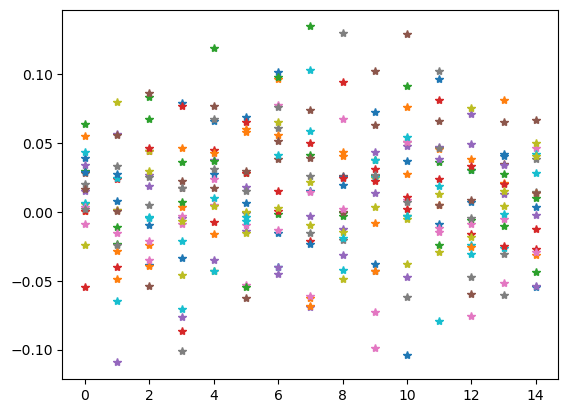

In [13]:
adc = nib.load(f'{cur_path}/data/ADC/adc_incl_weird_voxels.nii.gz')
adc = adc.get_fdata()

adc_to_plot = adc

for i in range(int(adc_to_plot.shape[3]/15)):
    plt.plot(adc_to_plot[16,70,6, i*15: (i+1)*15], '*')

In [38]:
# Analysis of task data (FEAT)
raw = nib.load(f'{cur_path}/data/dfMRI_raw.nii.gz')
header = raw.header

rest_block = 18
task_block = 12
TR = header["pixdim"][4]

No_dummies_out = 2
No_vol_DWI = header["dim"][4]+No_dummies_out


No_onsets = 1 + (No_vol_DWI - (rest_block - No_dummies_out))//(rest_block+task_block)

# Create txt file of experimental design
exper_design = np.zeros((No_onsets,3))

for i in range(No_onsets):
    exper_design[i, 0] = i*(rest_block+task_block)-No_dummies_out*TR+rest_block
    exper_design[i, 1] = task_block
    exper_design[i, 2] = 1

path_exp_design = f"{cur_path}/feat/exper_design.txt"
np.savetxt(path_exp_design, exper_design, '%.7f')


In [60]:
# Modify the design_tast.fsf file
replace_TR           = str(2*TR)
replace_No_volumes   = str(np.floor(No_vol_DWI/2))
replace_total_voxels = str(np.prod(header["dim"][1:5]))
replace_data    = f'{cur_path}/feat/adc'

os.system(f'cp {cur_path}/data/ADC/adc_incl_weird_voxels.nii.gz '
          f'{cur_path}/feat/adc.nii.gz')
os.system(f'cp {cur_path}/design_task.fsf '
          f'{cur_path}/feat/design_task.fsf')

# In the doc, they use s/what_to_replace/value_to_replace/g
# With path that uses "/", doesn't work
# => s:what_to_replace:value_to_replace:g
os.system(f'sed -i s:replace_TR:{replace_TR}:g {cur_path}/feat/design_task.fsf')
os.system(f'sed -i s:replace_No_volumes:{replace_No_volumes}:g '
          f'{cur_path}/feat/design_task.fsf')
os.system(f'sed -i s:replace_total_voxels:{replace_total_voxels}:g '
          f'{cur_path}/feat/design_task.fsf')
os.system(f'sed -i s:replace_data:{replace_data}:g {cur_path}/feat/design_task.fsf')
os.system(f'sed -i s:replace_design:{path_exp_design}:g {cur_path}/feat/design_task.fsf')
os.system(f'sed -i s:replace_FIR_window_length:{str(14*2*TR)}:g {cur_path}/feat/design_task.fsf')

os.system(f'feat {cur_path}/feat/design_task.fsf')

child process exited abnormally
    while executing
"fsl:exec "${FSLDIR}/bin/feat ${fsfroot}.fsf -D $FD -I $session -prestats" -b $prestatsTime -h $initID $jobHalt -N feat2_pre -l logs "
    (procedure "firstLevelMaster" line 168)
    invoked from within
"firstLevelMaster $session"
    invoked from within
"if { $done_something == 0 } {

    if { ! $fmri(inmelodic) } {
       if { $fmri(level) == 1 } {
	      for { set session 1 } { $session <= $fmri(mult..."
    (file "/home/localadmin/fsl/bin/feat" line 390)


256